# Automated classification of crowdsourcing contributions by machine learning

This model was developed in the context of my bachelor thesis. From more than 30 features, 12 features were selected below to determine a good quality crowdsourcing contribution. If you are interested in my bachelor thesis "Automatic Quality Control and Classification of Crowdsourcing Contributions by Machine Learning" (only German), please feel free to contact me at the following email address: philipp.niggli@student.unisg.ch

**Abstract** of my Bachelor Thesis:

Crowdsourcing is a new innovative form of a web-based business model and involves the work of a company or institution, outsourced to a distributed group of people over a network or platform, in the format of an open call. The manual review and classification of large amounts of unstructured data, such as solutions, ideas or feedback, is an enormous challenge for companies. It is usually a time-consuming and resource-intensive process. The results of this work show that it is possible to reliably classify and predict the quality of crowdsourcing contributions using text mining techniques and machine learning based on textual properties. The length of a contribution as a characteristic plays the most important role.

# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import nltk
import string
import textstat
from collections import Counter
from string import punctuation
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize 
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords 
from nltk.corpus import opinion_lexicon
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

# Import Data

In [2]:
file = pd.ExcelFile('Daten.xlsx')
df = file.parse('Worksheet')
feedbacks = df['like'].values
df['feedbacks'] = df['like']

# Pre-Processing

**Punctuation removal**

Source: https://medium.com/@pemagrg/pre-processing-text-in-python-ad13ea544dae

In [3]:
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation) 

**Tokenizer**

Source: https://www.nltk.org

In [4]:
def tokenizer(text):
    return nltk.word_tokenize(text)

**Part of speech tagging**

Source: https://www.nltk.org

In [5]:
def tagging(tokens):
    return nltk.pos_tag(tokens)

**Stemming**

Source: http://www.nltk.org/howto/stem.html

In [6]:
def stemming(text):
    stemmer = SnowballStemmer("english")    
    return stemmer.stem(text)

**Stop word Filtering**

Source: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

In [7]:
def stopword(text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [] 
    
    for w in word_tokens: 
         if w not in stop_words: 
             filtered_sentence.append(w) 

# Features

**Average number of letters per sentence**

In [8]:
def averageLetters(feedback):
    #number of sentence
    sentences = sent_tokenize(feedback)
    countSentences = len(sentences)
    
    #number of letters
    letterCount = len(strip_punctuation(feedback))
    
    average = letterCount / countSentences
    return average

df['1'] = df['feedbacks'].apply(averageLetters)

**Syllable percentage** of letters

In [9]:
def syllablePercentage(feedback):
    letterCount = len(strip_punctuation(feedback))
    syllableCount = textstat.syllable_count(feedback, lang='en_GB')
    syllablePercentage = syllableCount / letterCount
    return syllablePercentage
   
df['2'] = df['feedbacks'].apply(syllablePercentage)

**Average number of words per sentence**

In [10]:
def averageWords(feedback):
    #number of sentence
    sentences = sent_tokenize(feedback)
    countSentences = len(sentences)
    
    #number of words
    tokens = tokenizer(strip_punctuation(feedback)) 
    tokensCount = len(tokens) #count tokens
    
    average = tokensCount / countSentences
    return average

df['3'] = df['feedbacks'].apply(averageWords)

**Coleman Liau Index**

Source: https://pypi.org/project/textstat/

In [11]:
def colemanLiau(feedback):
    index = textstat.coleman_liau_index(feedback)
    return index

df['4'] = df['feedbacks'].apply(colemanLiau)

**Commas count**

In [12]:
def commaCount(feedback):
    #number of ","
    commaCount=0
    my_word=","
    if my_word in feedback:
        commaCount += 1
    return commaCount

df['5'] = df['feedbacks'].apply(commaCount)

**"!" and "?" count**

In [13]:
def explanationCount(feedback):    
    #number of "!"
    count1 = feedback.count("!")
    count2 = feedback.count("?")
    countSum = count1 + count2  
    return countSum

df['6 & 7'] = df['feedbacks'].apply(explanationCount)

**Sentence count**

Source: https://pypi.org/project/textstat/

In [14]:
def sentenceCount(feedback):
    sentenceCount = textstat.sentence_count(feedback)
    return sentenceCount
    
df['8'] = df['feedbacks'].apply(sentenceCount)

**Syllable Count**

Source: https://pypi.org/project/textstat/

In [15]:
def syllableCount(feedback):
    syllableCount = textstat.syllable_count(feedback, lang='en_GB')
    return syllableCount

df['9'] = df['feedbacks'].apply(syllableCount)

**Sentiment Analysis**

Source: https://www.nltk.org/_modules/nltk/sentiment/util.html#demo_liu_hu_lexicon

In [16]:
def sentimentCount(feedback):    
    pos_words = 0
    neg_words = 0
    tokens = tokenizer(feedback)
    
    for word in tokens:
        if word in opinion_lexicon.positive():
            pos_words += 1
        elif word in opinion_lexicon.negative():
            neg_words += 1
            
    sentiment_words = pos_words + neg_words
    return sentiment_words
  
df['10'] = df['feedbacks'].apply(sentimentCount)

**Noun percentage**

In [17]:
def nounPercentage(feedback):
    tokens = tokenizer(strip_punctuation(feedback))
    tagged = tagging(tokens) 
    counts = Counter( tag for word,  tag in tagged) #counts tags
    tokensCount = len(tokens) #count tokens
    countNoun = counts['NN'] + counts['NNS'] + counts['NNP'] + counts['NNPS']  #count noun
    nounPercentage = countNoun / tokensCount * 100
    return nounPercentage
    
df['11'] = df['feedbacks'].apply(nounPercentage)

**Adjective / Adverb percentage**

In [18]:
def adjectivePercentage(feedback):
    tokens = tokenizer(strip_punctuation(feedback))
    tagged = tagging(tokens) 
    counts = Counter( tag for word,  tag in tagged) #counts tags
    tokensCount = len(tokens) #count tokens
    countAdjective = counts['RB'] + counts['RBR'] + counts['RBS'] + counts['JJ'] + counts['JJR'] + counts['JJS'] + counts['WRB']#count adjective and adverb
    adjectivePercentage = countAdjective / tokensCount * 100
    return adjectivePercentage

df['12'] = df['feedbacks'].apply(adjectivePercentage)

# Machine Learning

For this classifier the Random Forest algorithm was used with 1000 decision trees and a maximum depth of 10. Other types of machine learning algorithms, ensemble methods and PCA were not considered in this study.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [19]:
X = df.iloc[:,8:26]
y = df['like_usefulness_binary']
clf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)

# Evaluation

**Cross Validation** for caluclating accurancy, sensitivity, specificity and precision

In [20]:
accuracy_model = []
sensitivity = []
specificity = []
precision = []
confusion_model2 = []

kf = KFold(n_splits=10,shuffle=False)

for train_index, test_index in kf.split(X):
    # Split train-test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Train the model
    model = clf.fit(X_train, y_train)
    # Append to accuracy_model the accuracy of the model
    accuracy_model.append(accuracy_score(y_test, model.predict(X_test), normalize=True))# Print the accuracy   
    
    confusion_model = confusion_matrix(y_test, model.predict(X_test))
    sensitivity1 = confusion_model[1,1]/(confusion_model[1,1]+confusion_model[1,0])
    specificity1 = confusion_model[0,0]/(confusion_model[0,0]+confusion_model[0,1])
    precision1 = confusion_model[1,1]/(confusion_model[1,1]+confusion_model[0,1])
    
    sensitivity.append(sensitivity1)
    specificity.append(specificity1)
    precision.append(precision1)
    confusion_model1 = np.array(confusion_model)
    confusion_model2.append(confusion_model1) 

print("Accuracy: %0.4f (+/- %0.4f)" % (np.mean(accuracy_model), np.std(accuracy_model)))
print("Sensitivity: %0.4f" % (np.mean(sensitivity)))
print("Specificity: %0.4f" % (np.mean(specificity)))
print("Precision: %0.4f" % (np.mean(precision)))

array = sum(confusion_model2)
print(array)

Accuracy: 0.8462 (+/- 0.0373)
Sensitivity: 0.9107
Specificity: 0.6986
Precision: 0.8690
[[ 74  29]
 [ 19 190]]


**Confusion Matrix**

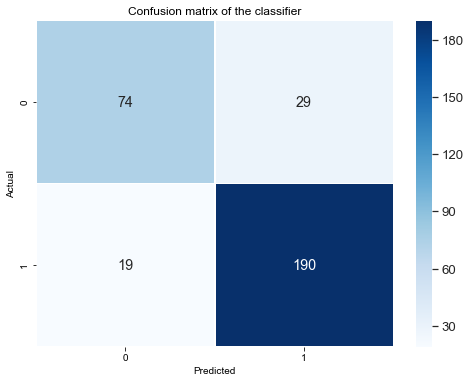

In [21]:
data = array
df_cm = pd.DataFrame(data)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.figure(figsize = (8,6))
plt.title('Confusion matrix of the classifier')
sn.set(font_scale=1.2)#for label size
ax = sn.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", linewidths=.5)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

**Feature importance**

[0.12744365 0.063924   0.09779157 0.10503231 0.02305229 0.00816281
 0.07465392 0.30133087 0.05733119 0.07331885 0.06795855]


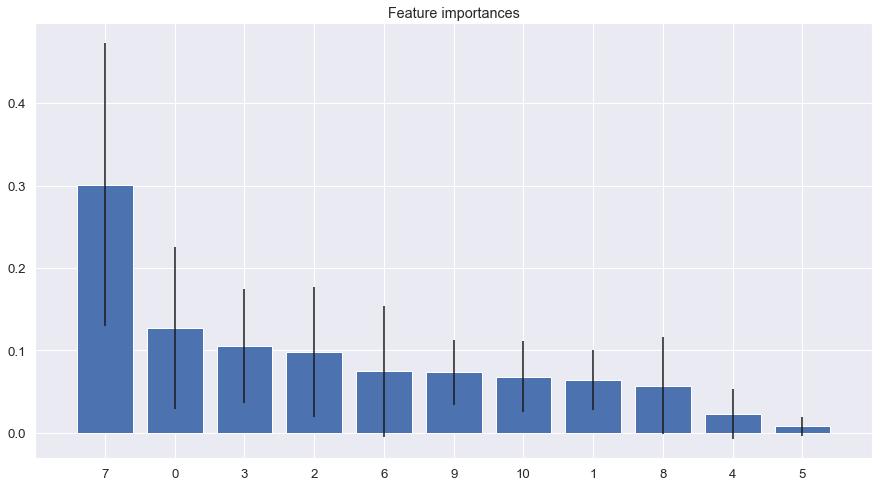

In [22]:
importances = clf.feature_importances_
print(clf.feature_importances_)

std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize = (15,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

**Feature correlation matrix**

Source: https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas/50703596

In [23]:
data = X
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,1,2,3,4,5,6 & 7,8,9,10,11,12
1,1,-0.0493733,0.989262,0.310347,0.262749,0.0102989,-0.157018,0.359132,0.208805,-0.0516423,0.0019666
2,-0.0493733,1,-0.0539987,-0.0111353,-0.0392121,0.0206676,-0.0944135,-0.0451156,-0.128129,0.13238,-0.0654125
3,0.989262,-0.0539987,1,0.194709,0.281921,0.0152949,-0.14473,0.370995,0.206662,-0.103982,-0.0183579
4,0.310347,-0.0111353,0.194709,1,0.0384312,-0.0179565,-0.0698065,0.107273,0.0592804,0.183044,0.169395
5,0.262749,-0.0392121,0.281921,0.0384312,1,0.128837,0.250104,0.386018,0.308481,-0.111124,0.0818227
6 & 7,0.0102989,0.0206676,0.0152949,-0.0179565,0.128837,1,0.178697,0.204105,0.13175,-0.0157343,-0.052681
8,-0.157018,-0.0944135,-0.14473,-0.0698065,0.250104,0.178697,1,0.7695,0.641644,-0.157254,0.00155006
9,0.359132,-0.0451156,0.370995,0.107273,0.386018,0.204105,0.7695,1,0.667814,-0.138923,-0.0637928
10,0.208805,-0.128129,0.206662,0.0592804,0.308481,0.13175,0.641644,0.667814,1,-0.243913,0.164773
11,-0.0516423,0.13238,-0.103982,0.183044,-0.111124,-0.0157343,-0.157254,-0.138923,-0.243913,1,-0.315332


**ROC Curve**

Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-download-auto-examples-model-selection-plot-roc-crossval-py

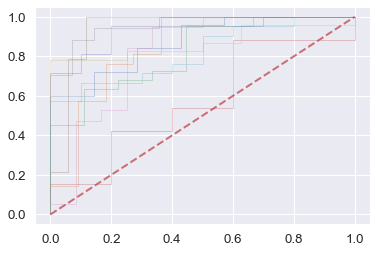

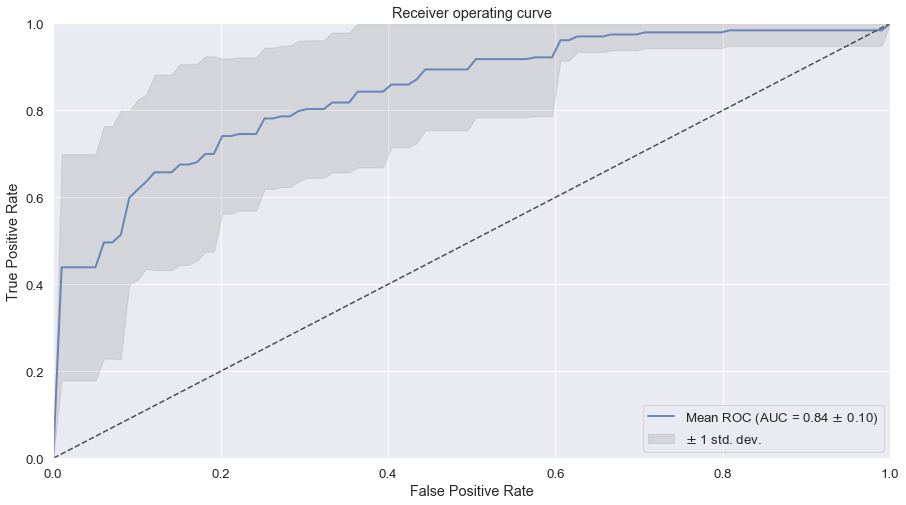

In [24]:
X = df.iloc[:,8:26]
y = df['like_usefulness_binary']
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
kf = KFold(n_splits=10,shuffle=False)
classifier = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0

#for train, test in cv.split(X, y):
for train, test in kf.split(X):
    prediction = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.figure(figsize = (15,8))
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating curve')
plt.legend(loc="lower right")
plt.show()
